In [1]:
%matplotlib notebook

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools_RTST as nt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Implement dataset module for COCO dataset

In [3]:
class COCODataset(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(256, 256)):
        super(COCODataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.images_dir = os.path.join(root_dir, mode + ('2015' if mode == 'test' else '2014'))
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "COCODataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        img = Image.open(img_path).convert('RGB')
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
            ])
        img = transform(img)
        return img

In [4]:
def myimshow(image, ax=plt):
    image = image.to('cpu').detach().numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

<IPython.core.display.Javascript object>


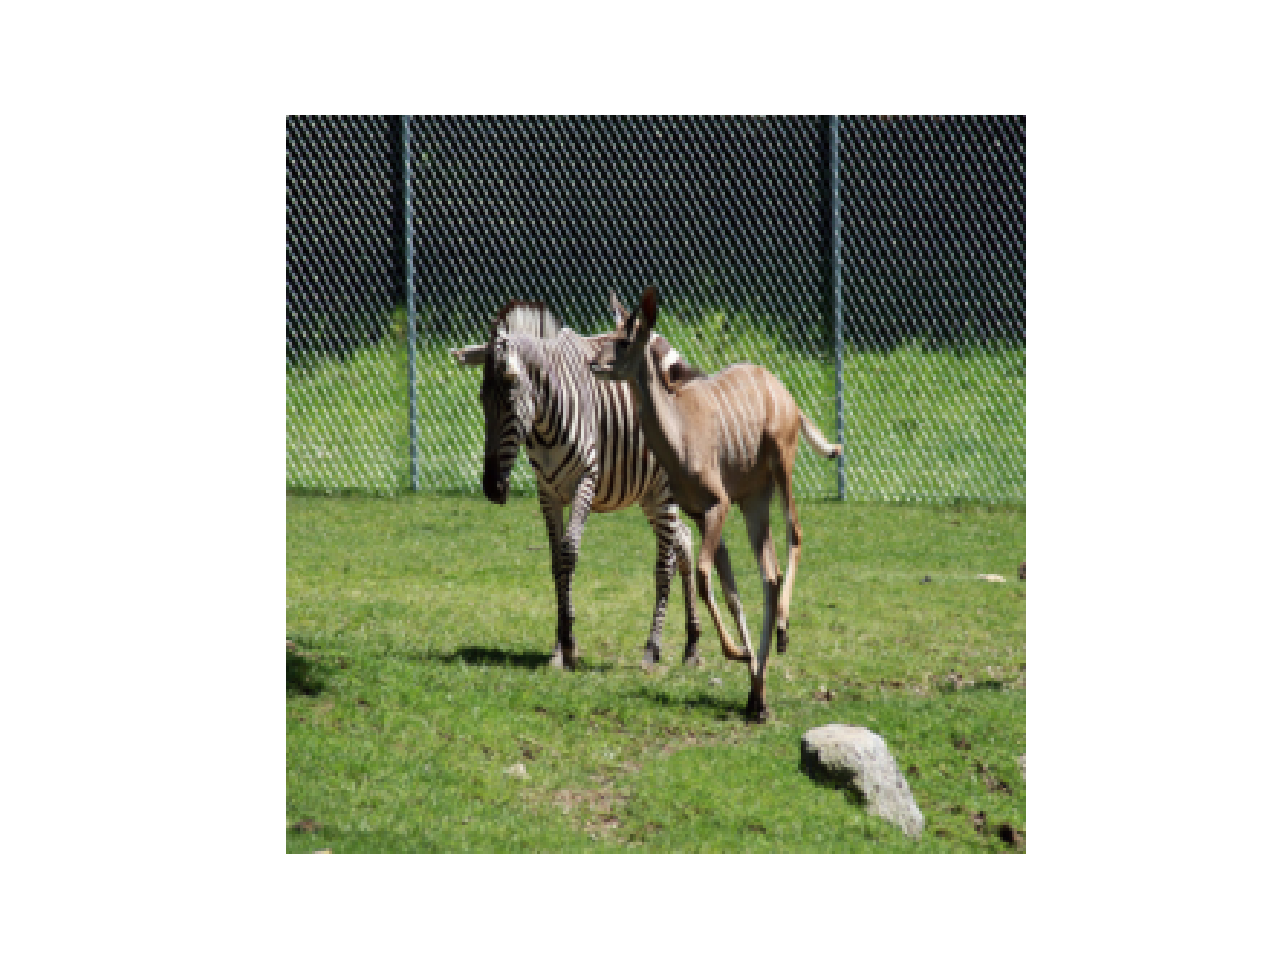

In [5]:
dataset_root_dir = '/datasets/COCO-2015'
train_set = COCODataset(dataset_root_dir, 'train')
val_set = COCODataset(dataset_root_dir, 'val')
test_set = COCODataset(dataset_root_dir, 'test')
x = test_set[8]
myimshow(x)

## Define loss network

In [6]:
from collections import namedtuple

class Vgg16(torch.nn.Module):
    '''
    ref: https://github.com/pytorch/examples/blob/master/fast_neural_style/neural_style/vgg.py
    '''
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = tv.models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

##  Define image transformation network

In [7]:
def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std

def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [8]:
class TransformerNet(nt.NeuralNetwork):
    '''
    ref: https://github.com/pytorch/examples/blob/master/fast_neural_style/neural_style/transformer_net.py
    '''
    def __init__(self, content_weight, style_weight, loss_network, gram_style):
        super(TransformerNet, self).__init__()
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.loss_network = loss_network
        self.gram_style = gram_style
        self.mse_loss = nn.MSELoss()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()
        
    def criterion(self, x, y):
        x = normalize_batch(x)
        y = normalize_batch(y)
        features_x = self.loss_network(x)
        features_y = self.loss_network(y)
        content_loss = self.content_weight * self.mse_loss(features_y.relu2_2, features_x.relu2_2)
        style_loss = 0.
        for ft_y, gm_s in zip(features_y, self.gram_style):
            gm_y = gram_matrix(ft_y)
            style_loss += self.mse_loss(gm_y, gm_s[:len(x), :, :])
        style_loss *= self.style_weight
        return content_loss + style_loss

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

## Train image transformation network

<IPython.core.display.Javascript object>


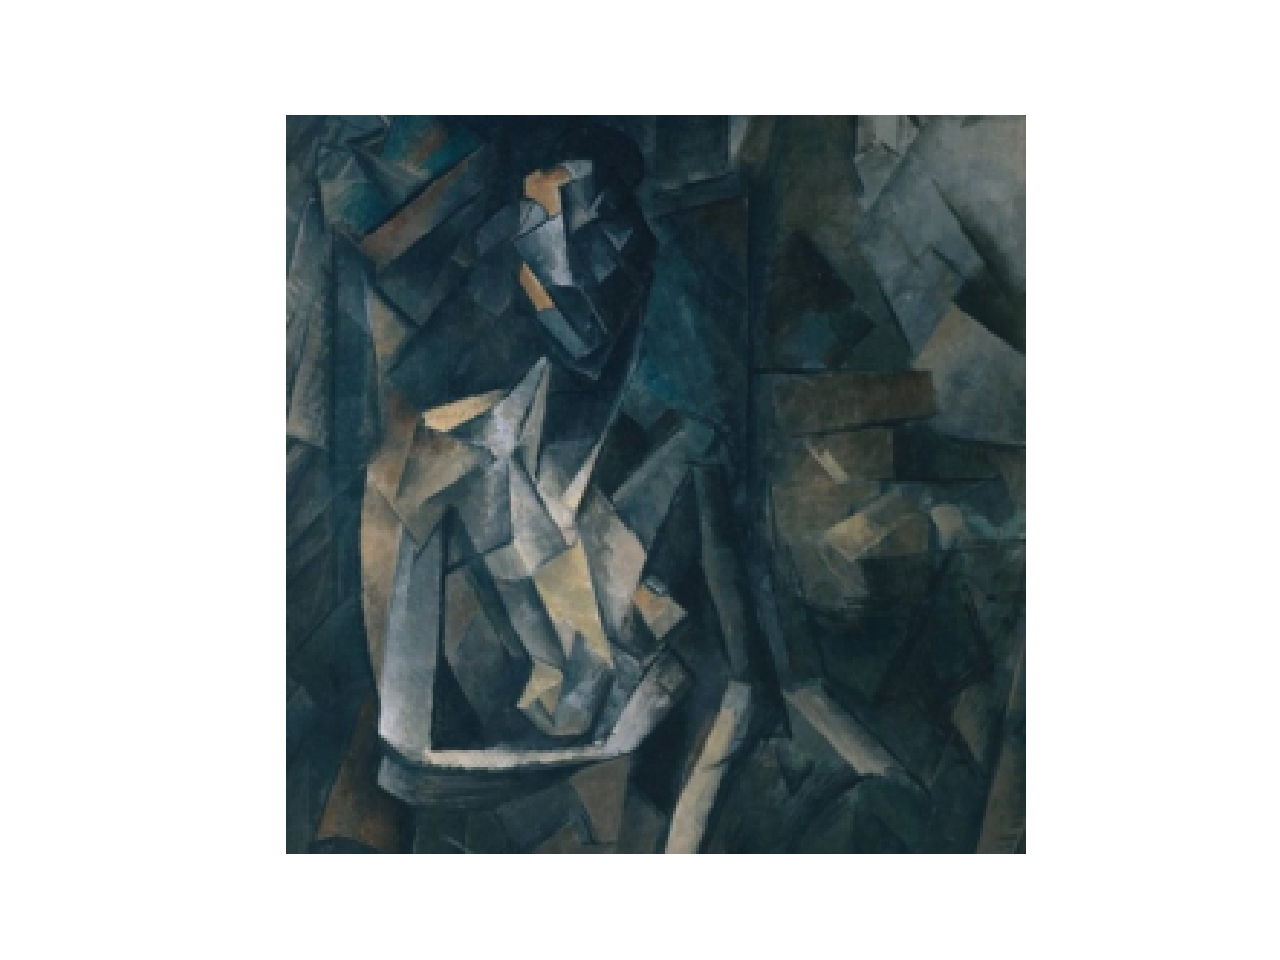

In [9]:
style = Image.open('./images/picasso.jpg').convert('RGB')
transform = tv.transforms.Compose([
            tv.transforms.Resize((256, 256)),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
            ])
style = transform(style)
myimshow(style)

<IPython.core.display.Javascript object>


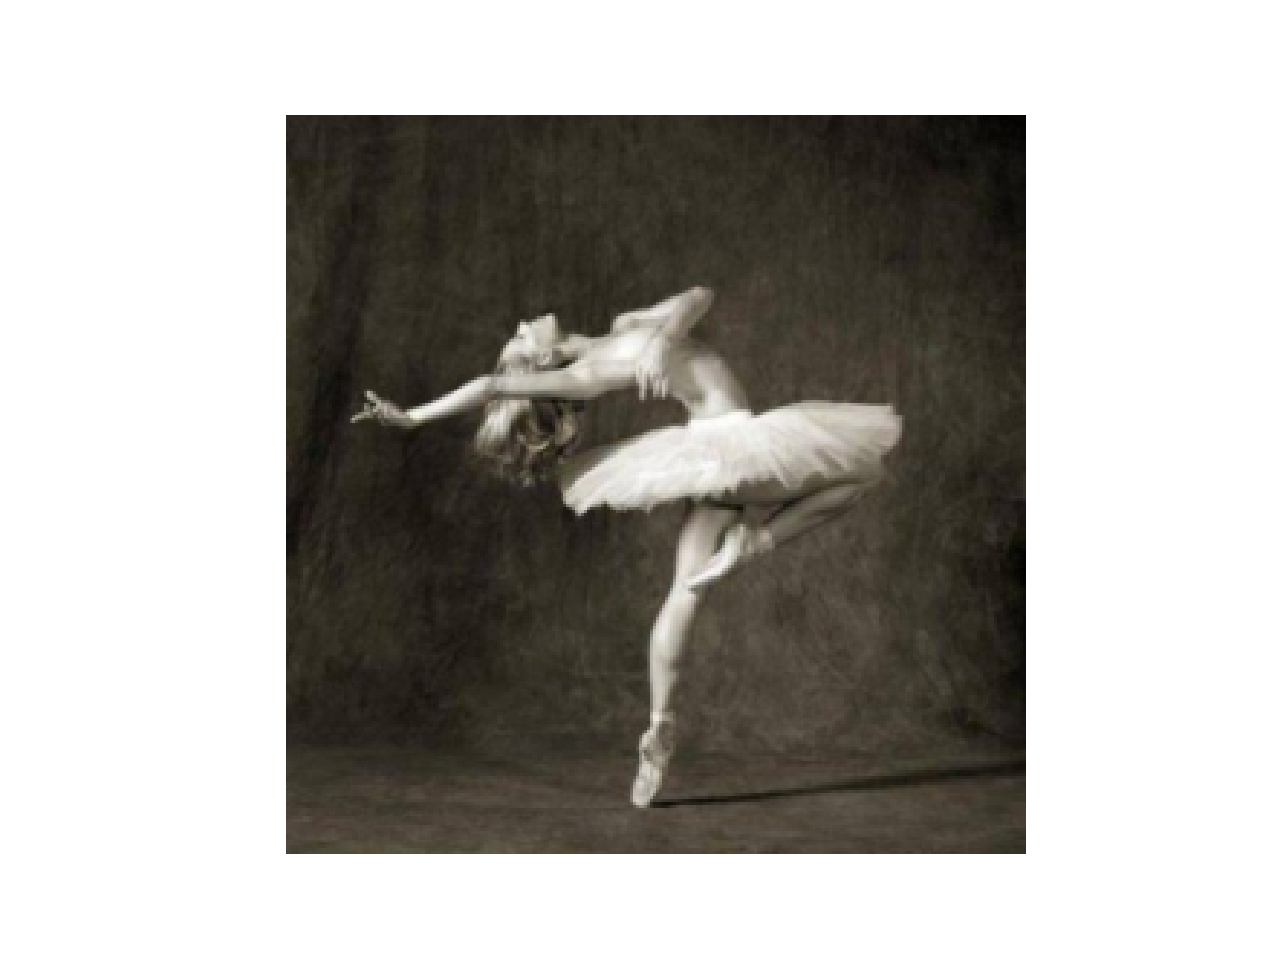

In [10]:
content = Image.open('./images/dancing.jpg').convert('RGB')
content = transform(content)
myimshow(content)

In [11]:
vgg = Vgg16(requires_grad=False).to(device)
batch_size = 4
style = style.repeat(batch_size, 1, 1, 1).to(device)
features_style = vgg(normalize_batch(style))
gram_style = [gram_matrix(y) for y in features_style]

In [12]:
net = TransformerNet(1e5, 1e10, vgg, gram_style)
net = net.to(device)
lr = 1e-3
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = nt.StatsManager()
exp = nt.Experiment(net, train_set, val_set, adam, stats_manager,
                output_dir="RTST", batch_size = batch_size, perform_validation_during_training = False)

In [13]:
def plot(exp, fig, axes, content):
    with torch.no_grad():
        transfer = exp.net(content[None].to(net.device))[0]
        axes[0].clear()
        axes[1].clear()
        myimshow(transfer, ax=axes[0])
        axes[0].set_title('transferred image')
        axes[1].plot([exp.history[k] for k in range(exp.epoch)], label="training loss")
        axes[1].legend()
        plt.tight_layout()
        fig.canvas.draw()

<IPython.core.display.Javascript object>


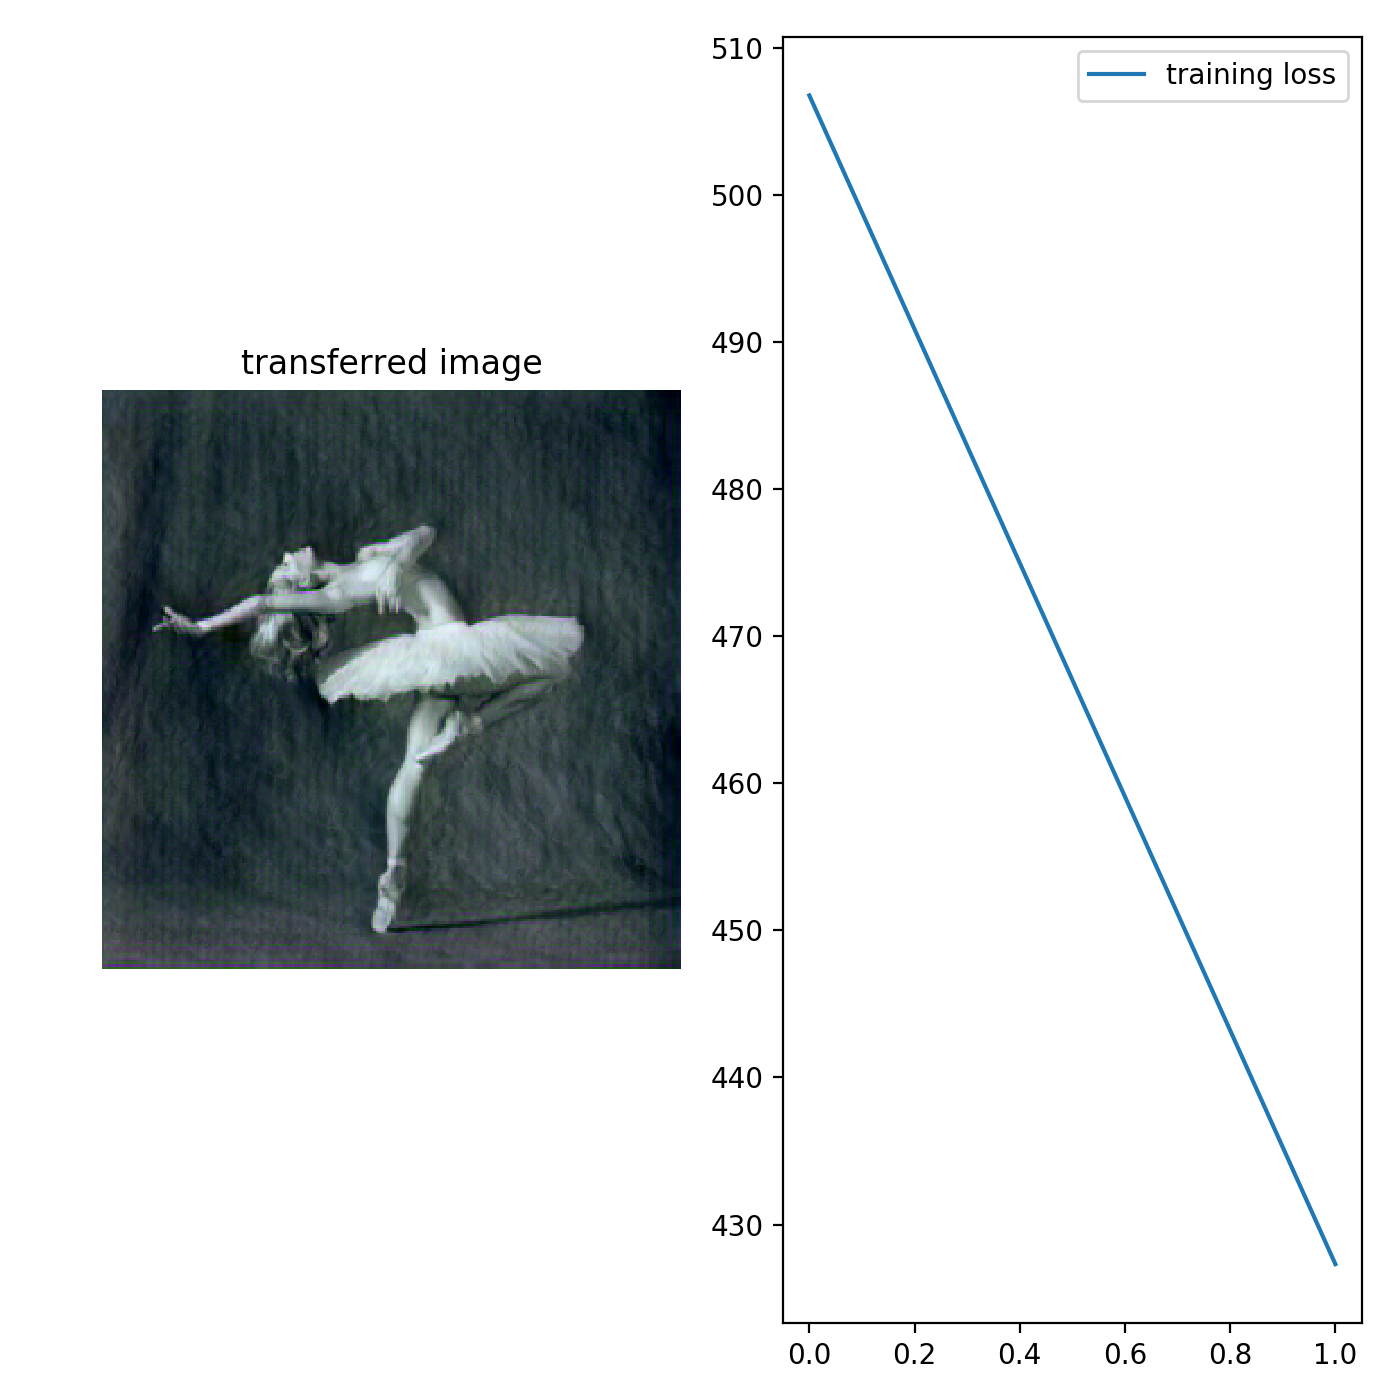

Start/Continue training from epoch 2
Finish training for 2 epochs


In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 7))
exp.run(num_epochs=2, plot=lambda exp: plot(exp, fig=fig, axes=axes, content=content))

In [15]:
torch.save(exp.net, 'transformer_picasso')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type TransformerNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Vgg16. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/

In [16]:
transformer = torch.load('transformer_picasso')

<IPython.core.display.Javascript object>


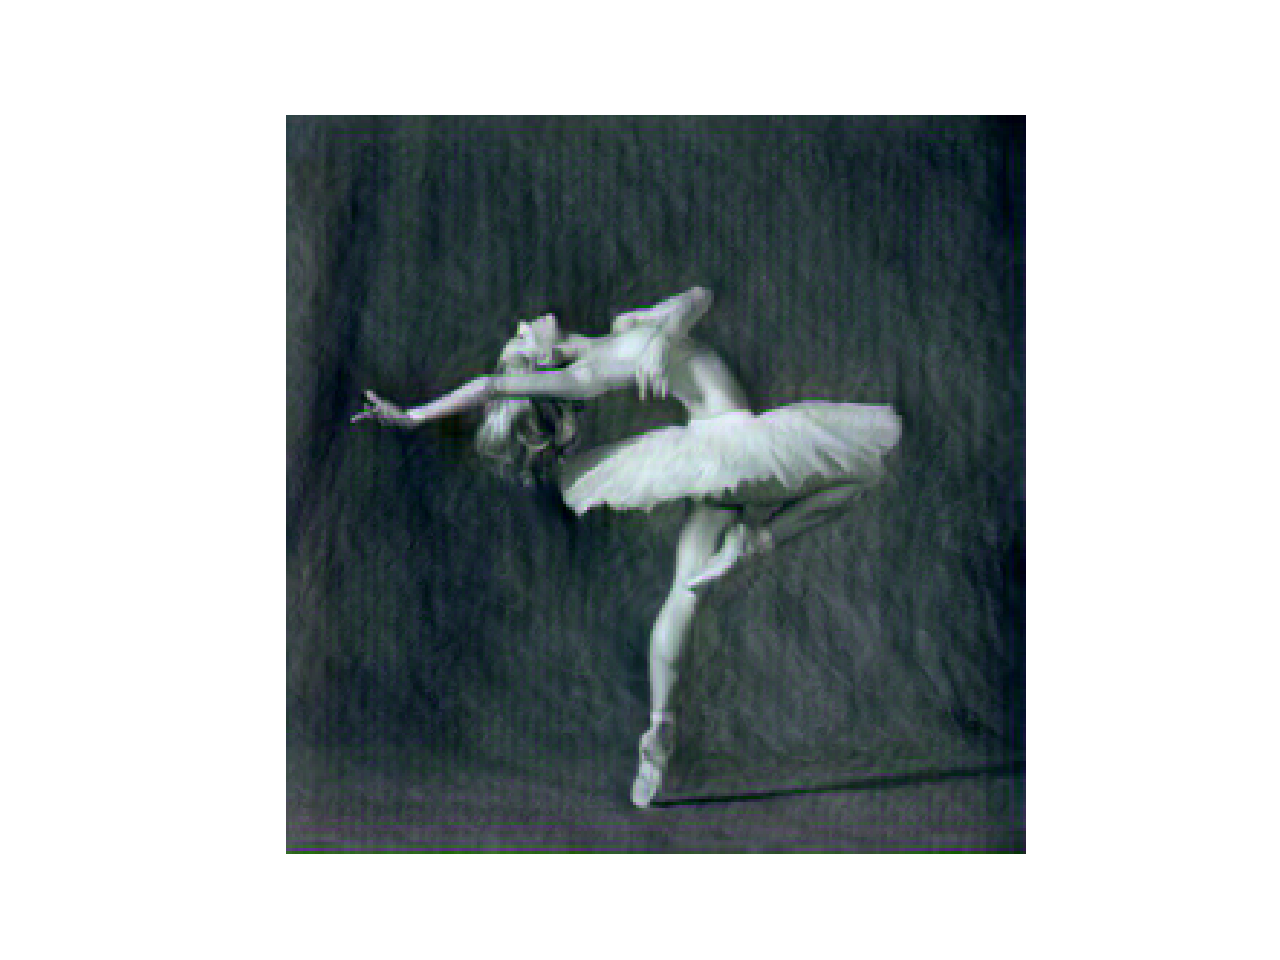

In [19]:
myimshow(transformer(content[None].to(net.device))[0])